In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from matplotlib import rcParams
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import preprocessing
import tests

DATA_FILE = "data.csv"


# Reading in Data

In [13]:
# preproccess() also removes any missing values replacing them with NaN
# preprocessing.preproccess()
df = pd.read_csv(DATA_FILE)

# Cleaning the Data

In [14]:
# remove rows containing AGEGP = 1, 2 and 3 to restrict analysis on ages 16+
df = df.loc[df["AGEGP"] > 3]
# keep rows where people make more than 0 income
df = df.loc[df['ATINC'] > 0]
# keep rows where people have more than 0 market income
df = df.loc[df['MTINC'] > 0]
# keep rows where people have more than 0 wages and salaries 
df = df.loc[df['WGSAL'] > 0]
# keep rows where people have more than 0 income tax 
df = df.loc[df['INCTX'] > 0]
# sorting by after tax income
df = df.sort_values(by=['ATINC'])
# selecting relevant variables 
df = df[["FWEIGHT", "PROV", "AGEGP", "SEX", "MARSTP", "HLEV2G", "SCSUM", "USHRWK", "IMMST", "MAJRI", "ATINC", "INCTX", "MTINC", "WGSAL"]]  # FDITX, GTR, RPPC 
df.head()

FWEIGHT  PROV  AGEGP  SEX  MARSTP  HLEV2G  SCSUM  USHRWK  IMMST  \
61614   156.2869  47.0   13.0  2.0     1.0     3.0   30.0     NaN    2.0   
43864  1462.6660  35.0   13.0  1.0     1.0     4.0   12.0    15.0    2.0   
93215   120.0783  10.0   13.0  2.0     1.0     3.0   30.0     NaN    2.0   
76174    68.8072  35.0   12.0  2.0     1.0     3.0   11.0    80.0    2.0   
62399   107.0503  10.0   13.0  2.0     1.0     3.0   22.0     8.0    NaN   

       MAJRI  ATINC   INCTX   MTINC     WGSAL  
61614    2.0  125.0  1550.0  1675.0     950.0  
43864    2.0  250.0  4650.0  4725.0    2800.0  
93215    2.0  310.0   790.0  1100.0    1100.0  
76174    2.0  440.0    60.0   500.0  100000.0  
62399    2.0  480.0   720.0  1200.0    1200.0

In [15]:
# Checking for missing values 
df = df.dropna()
df.isnull().sum().sum()

0

# Exploratory Data Analysis

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35514 entries, 43864 to 9818
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   FWEIGHT  35514 non-null  float64
 1   PROV     35514 non-null  float64
 2   AGEGP    35514 non-null  float64
 3   SEX      35514 non-null  float64
 4   MARSTP   35514 non-null  float64
 5   HLEV2G   35514 non-null  float64
 6   SCSUM    35514 non-null  float64
 7   USHRWK   35514 non-null  float64
 8   IMMST    35514 non-null  float64
 9   MAJRI    35514 non-null  float64
 10  ATINC    35514 non-null  float64
 11  INCTX    35514 non-null  float64
 12  MTINC    35514 non-null  float64
 13  WGSAL    35514 non-null  float64
dtypes: float64(14)
memory usage: 4.1 MB


In [17]:
df.describe()

FWEIGHT          PROV         AGEGP           SEX        MARSTP  \
count  35514.000000  35514.000000  35514.000000  35514.000000  35514.000000   
mean     385.328442     35.086586      9.538069      1.461001      1.971026   
std      434.636791     14.586388      2.588098      0.498484      1.222993   
min       10.003100     10.000000      4.000000      1.000000      1.000000   
25%      123.681450     24.000000      7.000000      1.000000      1.000000   
50%      211.014700     35.000000     10.000000      1.000000      1.000000   
75%      466.472200     47.000000     12.000000      2.000000      3.000000   
max     4808.771100     59.000000     15.000000      2.000000      4.000000   

             HLEV2G         SCSUM        USHRWK         IMMST         MAJRI  \
count  35514.000000  35514.000000  35514.000000  35514.000000  35514.000000   
mean       2.939939     13.204426     38.664349      1.858450      2.215464   
std        0.902458      4.127805     10.207358      0.348593      0.801458   
min        1.000000     11.000000      1.000000      1.000000      2.000000   
25%        2.000000     11.000000     35.000000      2.000000      2.000000   
50%        3.000000     11.000000     40.000000      2.000000      2.000000   
75%        4.000000     12.000000     40.000000      2.000000      2.000000   
max        4.000000     22.000000    168.000000      2.000000      7.000000   

               ATINC          INCTX         MTINC         WGSAL  
count   35514.000000   35514.000000  3.551400e+04  3.551400e+04  
mean    57110.848679   13364.537084  6.713565e+04  6.204617e+04  
std     36362.758515   19152.303368  5.496031e+04  5.051120e+04  
min       250.000000      10.000000  2.500000e+01  2.500000e+01  
25%     35290.000000    4050.000000  3.500000e+04  3.200000e+04  
50%     49230.000000    8510.000000  5.500000e+04  5.000000e+04  
75%     69697.500000   16360.000000  8.493750e+04  8.000000e+04  
max    922020.000000  561330.000000  1.340000e+06  1.250000e+06

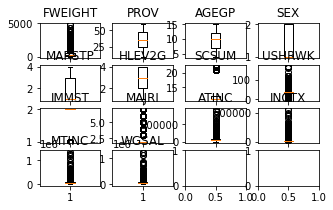

In [18]:
# matplotlib.rcParams['figure.figsize'] = [5, 3]
preprocessing.plot_boxplots(df, df.columns)

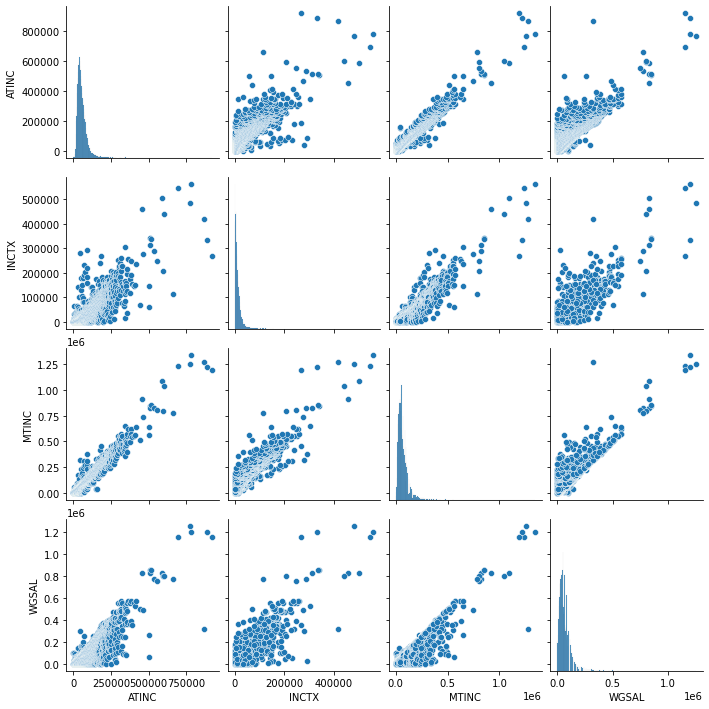

In [19]:
# Matrix scatter plot of data 
sns.pairplot(df[["ATINC", "INCTX", "MTINC", "WGSAL"]]);

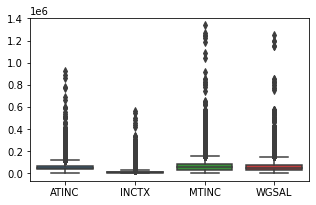

In [20]:
# Boxplot of data 
sns.boxplot(data=df[["ATINC", "INCTX", "MTINC", "WGSAL"]]);

In [21]:
# Correlation matrix 
df[["ATINC", "INCTX", "MTINC", "WGSAL"]].corr()

ATINC     INCTX     MTINC     WGSAL
ATINC  1.000000  0.866354  0.977113  0.900248
INCTX  0.866354  1.000000  0.938166  0.868472
MTINC  0.977113  0.938166  1.000000  0.928619
WGSAL  0.900248  0.868472  0.928619  1.000000

In [22]:
# making a copy of the dataframe to retain numeric values instead of strings for our model implementation later on
df_m = df.copy(deep=True)

In [23]:
# mapping groups from numeric to string
df['PROV'] = df['PROV'].map({59:'BC', 48:'AB', 47:'SA', 46:'MA', 35:'ON', 24:'QU', 13:'NB', 12:'NS', 11:'PE', 10:'NL'})
df['AGEGP'] = df['AGEGP'].map({4:'16-17', 5:'18-24', 6:'25-29', 7:'30-34', 8:'35-39', 9:'40-44', 10:'45-49', 11:'50-54', 12:'55-59', 13:'60-64', 14:'65-69', 15:'70+'})
df['SEX'] = df['SEX'].map({1:'Male', 2:'Female'})
df['MARSTP'] = df['MARSTP'].map({1:'Married', 2:'Common-Law', 3:'Separated', 4:'Single'})
df['HLEV2G'] = df['HLEV2G'].map({1:'Less than HS', 2:'Graduated HS', 3:'Certificate or Diploma', 4:'University Degree'})
df['SCSUM'] = df['SCSUM'].map({11:'Full-Year Full-Time', 12:'Full-Year Part-Time', 21:'Part-Year Full-Time', 22:'Part-Year Part-Time', 30:'Did not work during year'})
df['IMMST'] = df['IMMST'].map({1:'Immigrant', 2:'Non-Immigrant'})
df['MAJRI'] = df['MAJRI'].map({1:'No Income', 2:'Wages and Salary', 3:'Self-Employment', 4:'Government Transfers',5:'Investment',6:'Private Retirement Pensions', 7:'Other'})

In [24]:
# Log transforming data due to the distribution of variables being right skewed 
dflog = df.copy(deep=True)
logged_vars= dflog[["ATINC", "INCTX", "MTINC", "WGSAL"]].apply(lambda x: np.log(x))
dflog[["ATINC", "INCTX", "MTINC", "WGSAL"]] = logged_vars

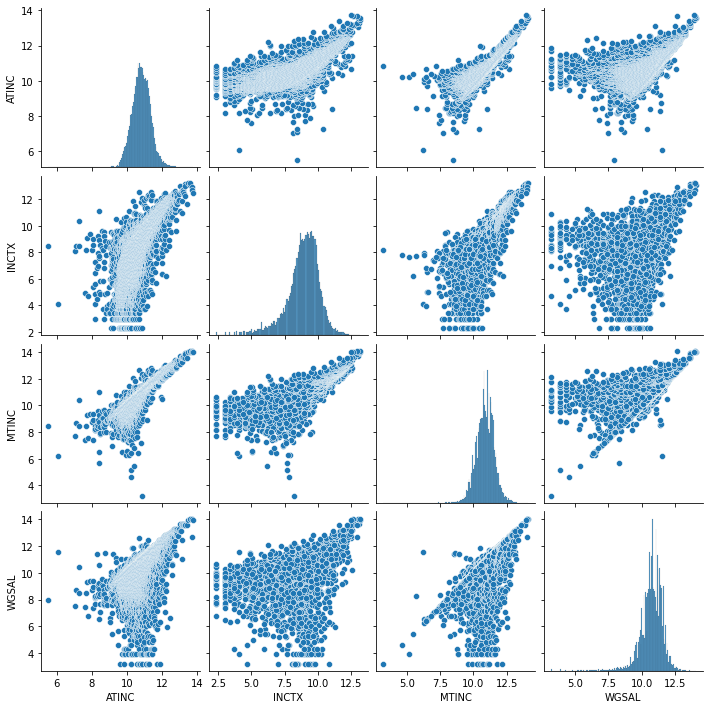

In [25]:
# Matrix scatter plot of log transformed data 
sns.pairplot(dflog[["ATINC", "INCTX", "MTINC", "WGSAL"]]);

### Statistical tests

In [26]:
tests.chi_test(df_m, 'HLEV2G', 'MARSTP')

MARSTP   1.0   2.0   3.0   4.0
HLEV2G                        
1.0     1163   367   239   567
2.0     4130  1217   707  2530
3.0     7101  2431  1286  2653
4.0     6988  1470   709  1956
Chi squared contingency tests for HLEV2G and MARSTP: 5.5590799301615676e-160


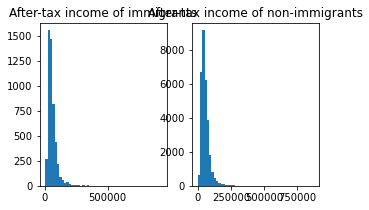

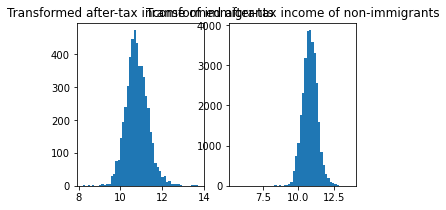

The means of Transformed after-tax income of immigrants and Transformed after-tax income of non-immigrants are not different.
57185.68927789934 57098.508216616916


In [27]:
tests.hyp_3(df_m)

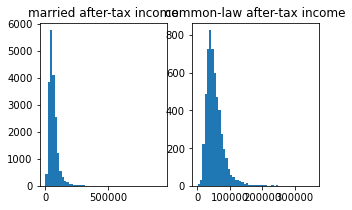

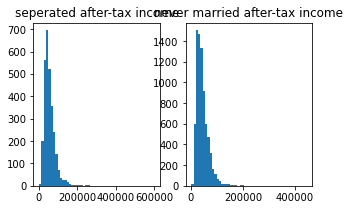

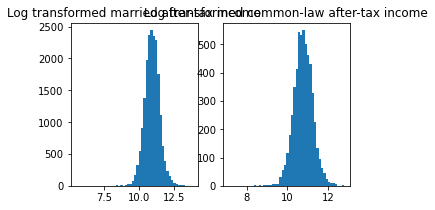

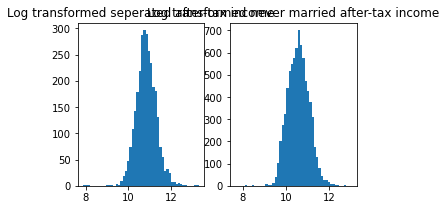

p-value:  0.0
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
    group1        group2    meandiff p-adj  lower   upper  reject
-----------------------------------------------------------------
   common_law       married    0.122  -0.0  0.1019  0.1421   True
   common_law never_married  -0.2039  -0.0 -0.2272 -0.1807   True
   common_law     seperated   0.0595   0.0  0.0295  0.0896   True
      married never_married  -0.3259  -0.0 -0.3436 -0.3083   True
      married     seperated  -0.0625   0.0 -0.0885 -0.0365   True
never_married     seperated   0.2635  -0.0   0.235   0.292   True
-----------------------------------------------------------------


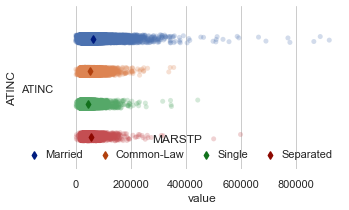

In [28]:
tests.anova(df_m)
tests.stripplot(df[['MARSTP', 'ATINC']], 'ATINC', 'MARSTP')

T-test p-value: 2.2288262599419633e-286
Levene-test p-value: 7.654918596973381e-25
Normality-test for male income p-value: 1.6346577775646034e-154
Normality-test for female income p-value; 9.385905027852281e-166


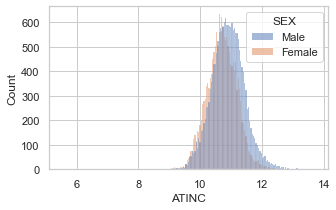

In [29]:
# Test whether a person's income is affected by their gender.
tests.income_gender(dflog)


anova p-value: 2.7979769362617976e-255 

                     Multiple Comparison of Means - Tukey HSD, FWER=0.05                      
           group1                      group2           meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------------------------
       Government Transfers                  Investment   0.7972    0.0  0.7173  0.8771   True
       Government Transfers                       Other   0.5511    0.0  0.4336  0.6686   True
       Government Transfers Private Retirement Pensions   0.5563    0.0  0.4839  0.6287   True
       Government Transfers             Self-Employment   0.3738    0.0  0.2841  0.4635   True
       Government Transfers            Wages and Salary   0.4952    0.0  0.4505  0.5399   True
                 Investment                       Other  -0.2461    0.0 -0.3738 -0.1183   True
                 Investment Private Retirement Pensions  -0.2409    0.0  -0.329 -0.1528   True
        

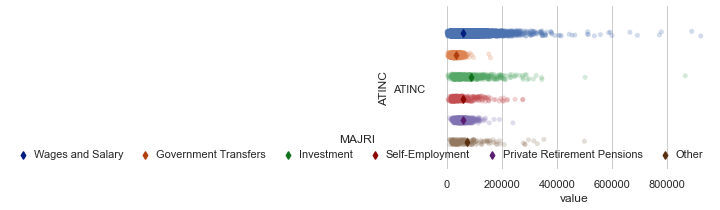

In [30]:
# Test to determine peoples major source of income difference 
tests.major_source(dflog)
tests.stripplot(df[['MAJRI', 'ATINC']], 'ATINC', 'MAJRI')

### Back TO EDA

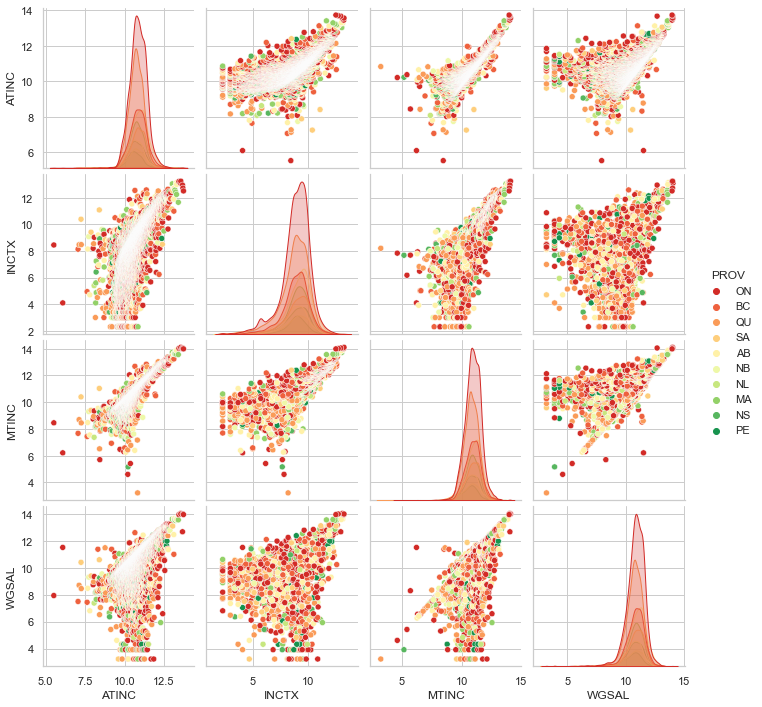

In [31]:
sns.pairplot(dflog[["ATINC", "INCTX", "MTINC", "WGSAL","PROV"]],hue="PROV",palette='RdYlGn');

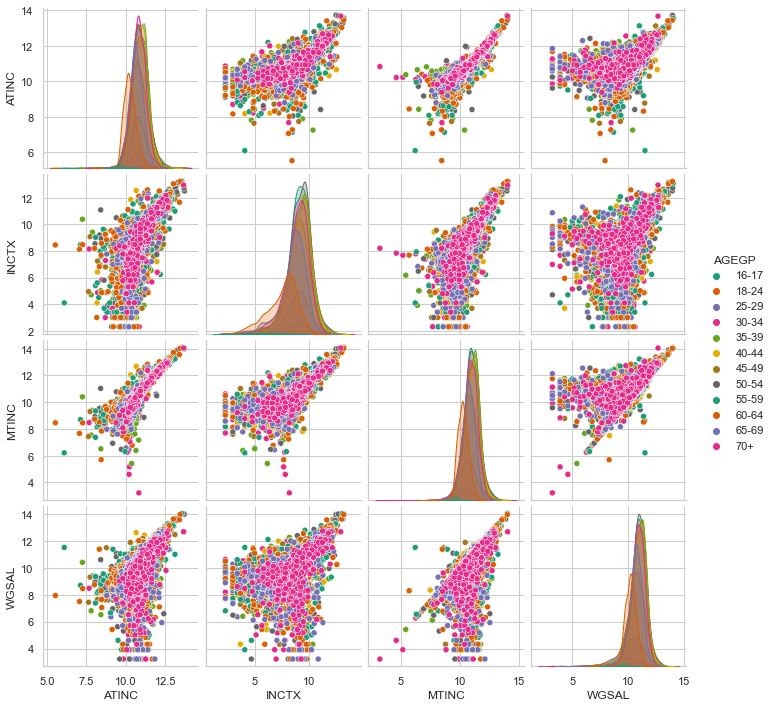

In [32]:
dflog = dflog.sort_values(by=['AGEGP'])
sns.pairplot(dflog[["ATINC", "INCTX", "MTINC", "WGSAL","AGEGP"]],hue="AGEGP",palette='Dark2');

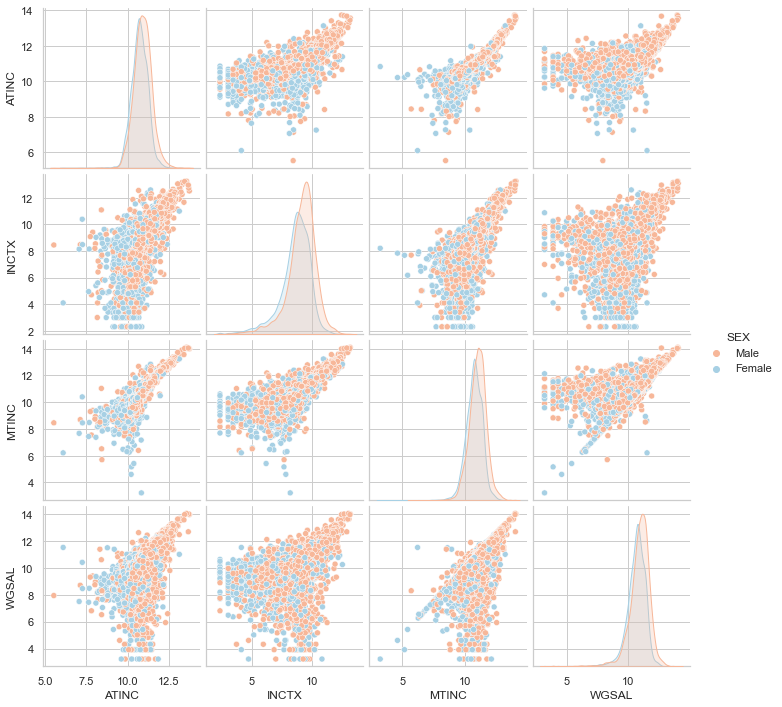

In [33]:
sns.pairplot(dflog[["ATINC", "INCTX", "MTINC", "WGSAL","SEX"]],hue="SEX", palette='RdBu');

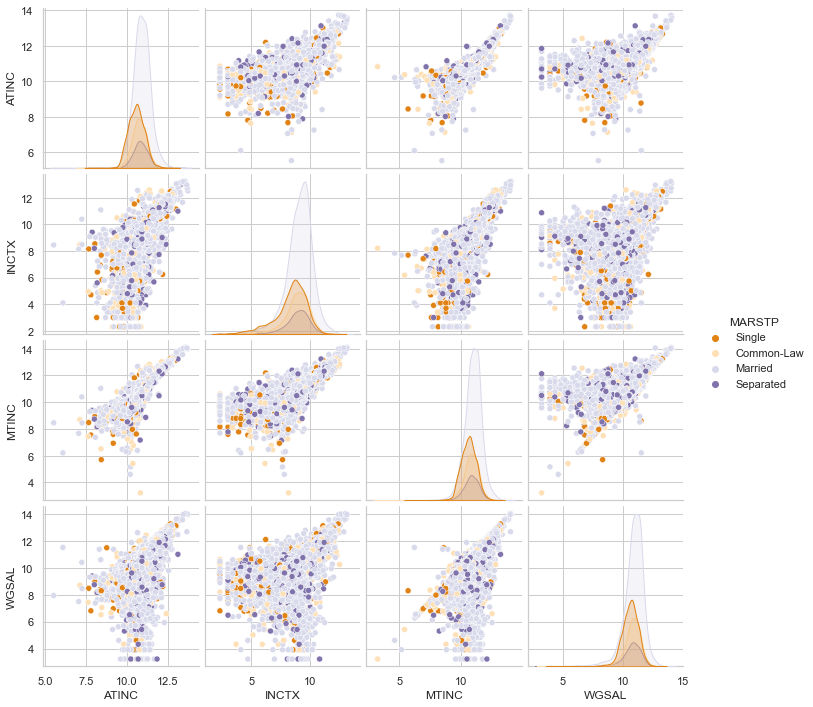

In [34]:
sns.pairplot(dflog[["ATINC", "INCTX", "MTINC", "WGSAL","MARSTP"]],hue="MARSTP",palette='PuOr');

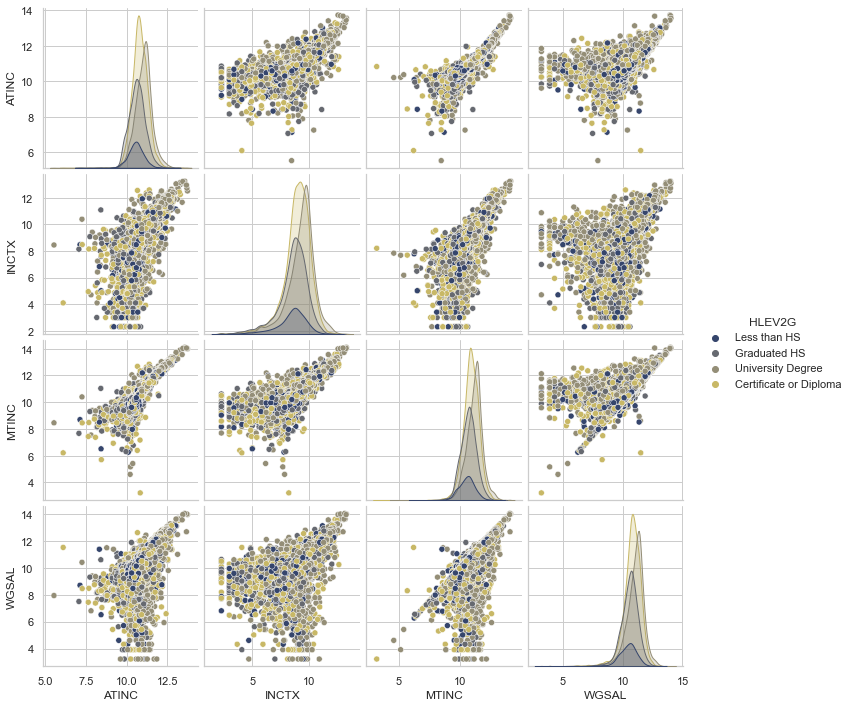

In [35]:
sns.pairplot(dflog[["ATINC", "INCTX", "MTINC", "WGSAL","HLEV2G"]],hue="HLEV2G",palette='cividis');

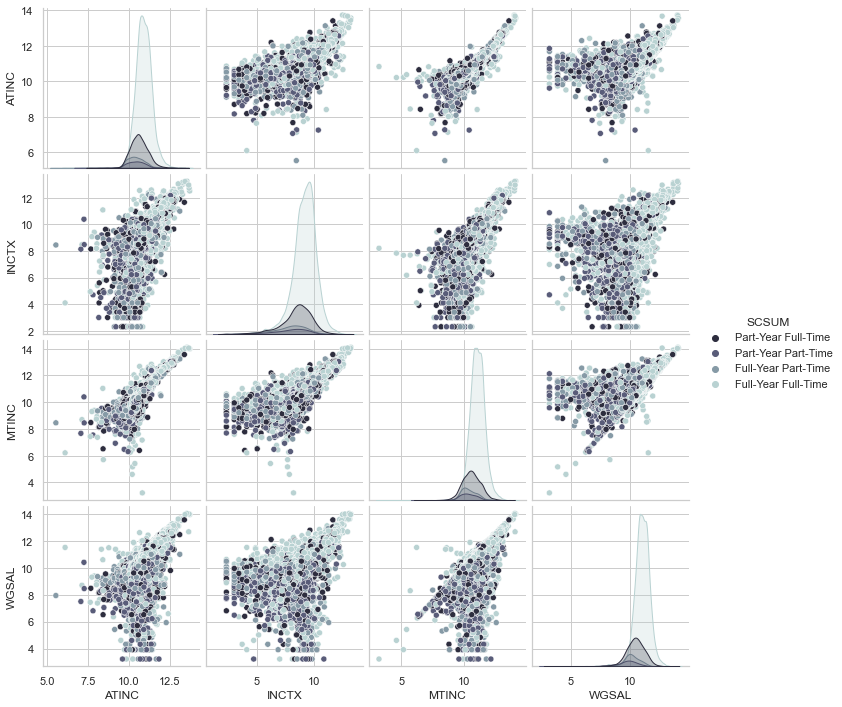

In [36]:
sns.pairplot(dflog[["ATINC", "INCTX", "MTINC", "WGSAL","SCSUM"]],hue="SCSUM",palette='bone');

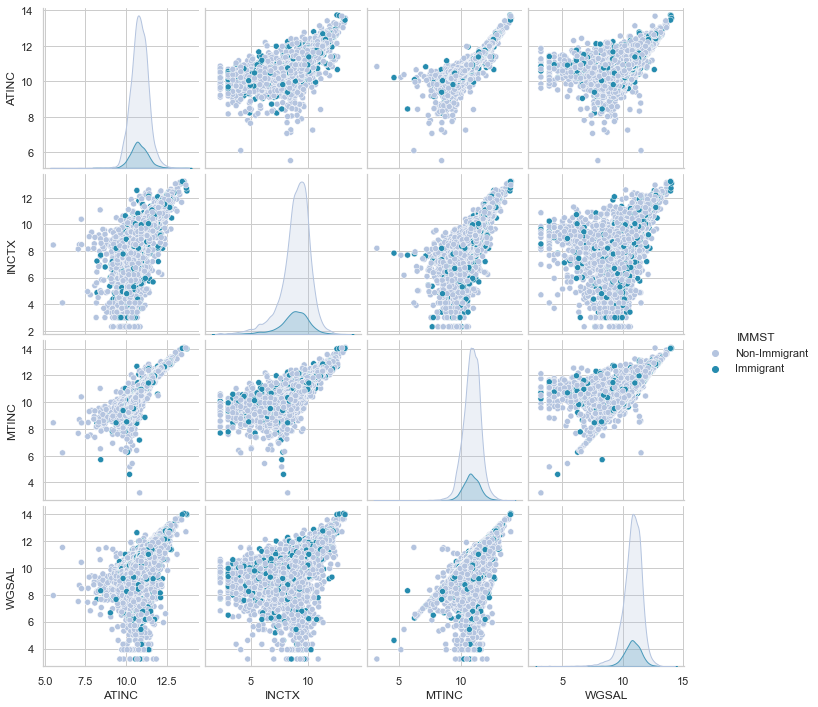

In [37]:
sns.pairplot(dflog[["ATINC", "INCTX", "MTINC", "WGSAL","IMMST"]],hue="IMMST",palette='PuBuGn');

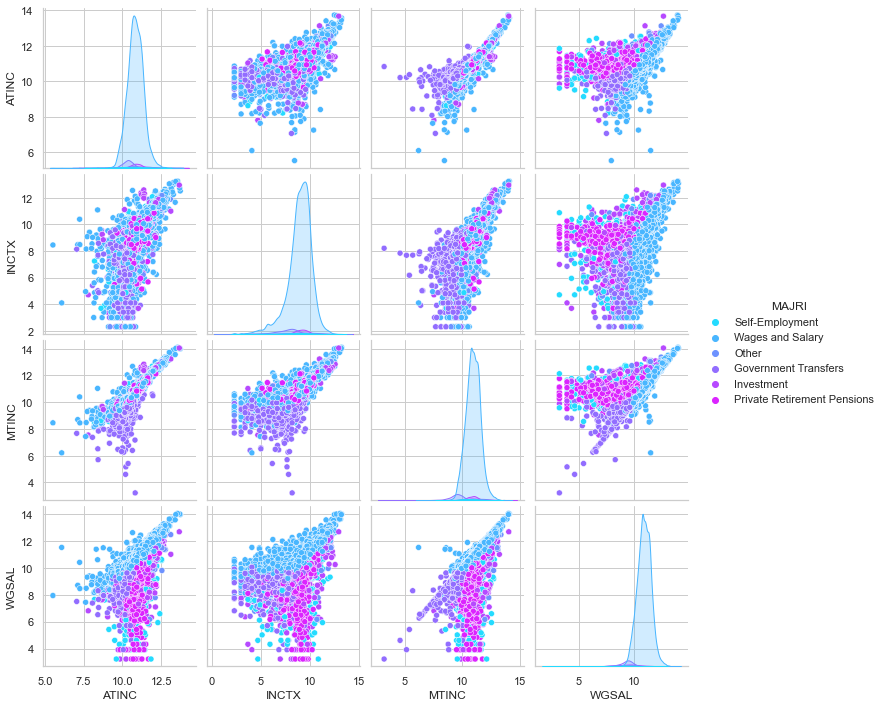

In [38]:
sns.pairplot(dflog[["ATINC", "INCTX", "MTINC", "WGSAL","MAJRI"]],hue="MAJRI",palette='cool');

In [39]:
# Categorical variables
cat_features = df[["PROV", "AGEGP", "SEX", "MARSTP", "HLEV2G", "SCSUM", "IMMST", "USHRWK", "MAJRI"]]
cat_features

PROV  AGEGP     SEX      MARSTP                  HLEV2G  \
43864   ON  60-64    Male     Married       University Degree   
76174   ON  55-59  Female     Married  Certificate or Diploma   
69759   BC  60-64  Female     Married            Graduated HS   
84275   QU  55-59    Male  Common-Law            Less than HS   
83158   SA  35-39  Female     Married       University Degree   
...    ...    ...     ...         ...                     ...   
52158   ON  55-59    Male     Married       University Degree   
46578   ON  45-49    Male     Married       University Degree   
37117   ON    70+    Male     Married       University Degree   
86503   ON  50-54    Male     Married       University Degree   
9818    ON  50-54    Male     Married       University Degree   

                     SCSUM          IMMST  USHRWK                 MAJRI  
43864  Full-Year Part-Time  Non-Immigrant    15.0      Wages and Salary  
76174  Full-Year Full-Time  Non-Immigrant    80.0      Wages and Salary  
69759  Part-Year Part-Time  Non-Immigrant    12.0  Government Transfers  
84275  Full-Year Full-Time  Non-Immigrant    60.0      Wages and Salary  
83158  Part-Year Part-Time  Non-Immigrant     3.0      Wages and Salary  
...                    ...            ...     ...                   ...  
52158  Full-Year Full-Time      Immigrant    40.0      Wages and Salary  
46578  Full-Year Full-Time  Non-Immigrant    75.0      Wages and Salary  
37117  Full-Year Full-Time  Non-Immigrant    44.0            Investment  
86503  Full-Year Full-Time      Immigrant    40.0      Wages and Salary  
9818   Full-Year Full-Time      Immigrant    40.0      Wages and Salary  

[35514 rows x 9 columns]

In [40]:
# distribution of the groups in each of the categorical variables
for col in list(cat_features.columns):
    print(col +' has '+ str(cat_features[col].nunique()) +' unique elements:\n ' + str(cat_features[col].unique())) 
    print('The distributions:')
    print(round(df[col].value_counts(normalize=True)*100,2).map(str)+'%') 
    print('\n')

PROV has 10 unique elements:
 ['ON' 'BC' 'QU' 'SA' 'AB' 'NB' 'NL' 'MA' 'NS' 'PE']
The distributions:
ON    27.88%
QU    18.53%
AB    11.42%
BC    11.09%
MA     7.94%
SA     7.07%
NB     5.03%
NS     4.83%
NL     3.51%
PE      2.7%
Name: PROV, dtype: object


AGEGP has 12 unique elements:
 ['60-64' '55-59' '35-39' '45-49' '30-34' '50-54' '18-24' '40-44' '65-69'
 '25-29' '16-17' '70+']
The distributions:
50-54    12.71%
55-59    12.67%
35-39    11.58%
45-49    11.54%
30-34    11.23%
40-44     11.1%
60-64     9.22%
25-29     8.69%
18-24     5.99%
65-69     3.95%
70+       1.17%
16-17     0.14%
Name: AGEGP, dtype: object


SEX has 2 unique elements:
 ['Male' 'Female']
The distributions:
Male      53.9%
Female    46.1%
Name: SEX, dtype: object


MARSTP has 4 unique elements:
 ['Married' 'Common-Law' 'Single' 'Separated']
The distributions:
Married       54.58%
Single         21.7%
Common-Law    15.44%
Separated      8.28%
Name: MARSTP, dtype: object


HLEV2G has 4 unique elements:
 ['Univer

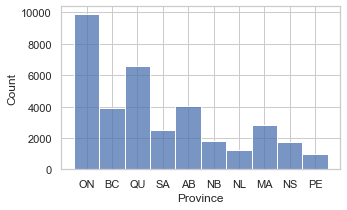

In [41]:
sns.histplot(data=df, x='PROV').set(xlabel='Province');

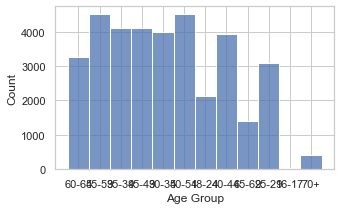

In [42]:
sns.histplot(data=df, x='AGEGP').set(xlabel='Age Group');

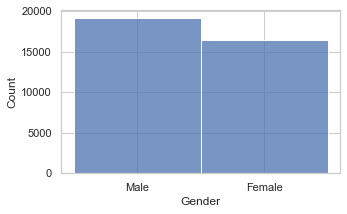

In [43]:
sns.histplot(data=df, x='SEX').set(xlabel='Gender');

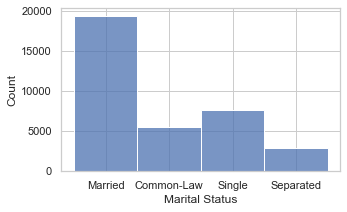

In [44]:
sns.histplot(data=df, x='MARSTP').set(xlabel='Marital Status');

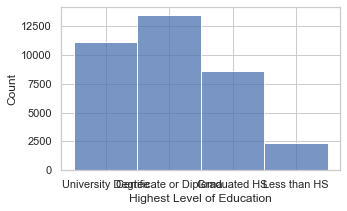

In [45]:
sns.histplot(data=df, x='HLEV2G').set(xlabel='Highest Level of Education');

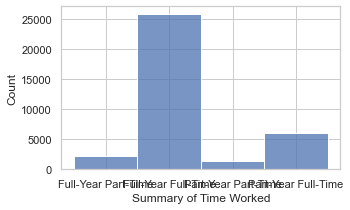

In [46]:
sns.histplot(data=df, x='SCSUM').set(xlabel='Summary of Time Worked');

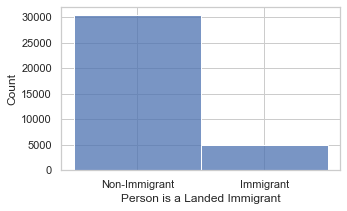

In [47]:
sns.histplot(data=df, x='IMMST').set(xlabel='Person is a Landed Immigrant');

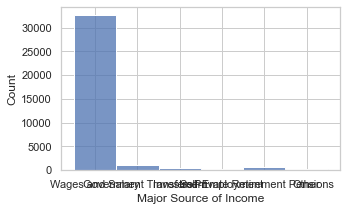

In [48]:
sns.histplot(data=df, x='MAJRI').set(xlabel='Major Source of Income');

In [49]:
# function to classify income levels 
def income_classifier(df):
    if df['ATINC'] <= 32048: return "Low"
    elif (df['ATINC'] > 32048) & (df['ATINC'] <= 53413): return "Lower-middle"
    elif (df['ATINC'] > 53413) & (df['ATINC'] <= 106827): return "Middle"
    elif (df['ATINC'] > 106827) & (df['ATINC'] <= 373894): return "Upper-middle"
    elif (df['ATINC'] > 373894): return "Upper"
# Reference: https://www.ictsd.org/what-income-class-are-you-canada/

# classifying ATINC variable (after tax income), with our income_classifier function 
income=[]
income =(pd.concat([cat_features, df["ATINC"]], axis=1))
income['ATINC'] = income.apply(income_classifier,axis=1)
income.head()

PROV  AGEGP     SEX      MARSTP                  HLEV2G  \
43864   ON  60-64    Male     Married       University Degree   
76174   ON  55-59  Female     Married  Certificate or Diploma   
69759   BC  60-64  Female     Married            Graduated HS   
84275   QU  55-59    Male  Common-Law            Less than HS   
83158   SA  35-39  Female     Married       University Degree   

                     SCSUM          IMMST  USHRWK                 MAJRI ATINC  
43864  Full-Year Part-Time  Non-Immigrant    15.0      Wages and Salary   Low  
76174  Full-Year Full-Time  Non-Immigrant    80.0      Wages and Salary   Low  
69759  Part-Year Part-Time  Non-Immigrant    12.0  Government Transfers   Low  
84275  Full-Year Full-Time  Non-Immigrant    60.0      Wages and Salary   Low  
83158  Part-Year Part-Time  Non-Immigrant     3.0      Wages and Salary   Low

In [50]:
# Distribution of income levels for the groups in each of our categorical variables
for col in income.columns:
    x= income.groupby([col,'ATINC'])['ATINC'].count() # counting the income level class per group within a categorical variable
    y= income.groupby([col])['ATINC'].count() # counting the total number of income level class per group within a categorical variable
    r = round((x/y)*100,2).map(str)+'%' 
    print(r)
    print('\n')

PROV  ATINC       
AB    Low             13.95%
      Lower-middle    31.14%
      Middle          41.96%
      Upper            0.15%
      Upper-middle     12.8%
BC    Low             18.08%
      Lower-middle    33.54%
      Middle           40.3%
      Upper             0.1%
      Upper-middle     7.97%
MA    Low             23.01%
      Lower-middle    39.35%
      Middle          33.36%
      Upper            0.21%
      Upper-middle     4.08%
NB    Low             24.97%
      Lower-middle    39.64%
      Middle          30.52%
      Upper            0.06%
      Upper-middle     4.82%
NL    Low             21.99%
      Lower-middle    37.96%
      Middle          34.75%
      Upper-middle      5.3%
NS    Low             23.94%
      Lower-middle    38.85%
      Middle          33.72%
      Upper-middle     3.49%
ON    Low             17.74%
      Lower-middle    35.29%
      Middle          40.27%
      Upper            0.09%
      Upper-middle     6.62%
PE    Low             27

In [51]:
# updating dataframes with income level classification 
df['ATINC'] = income['ATINC']
df_m['ATINC'] = income['ATINC']

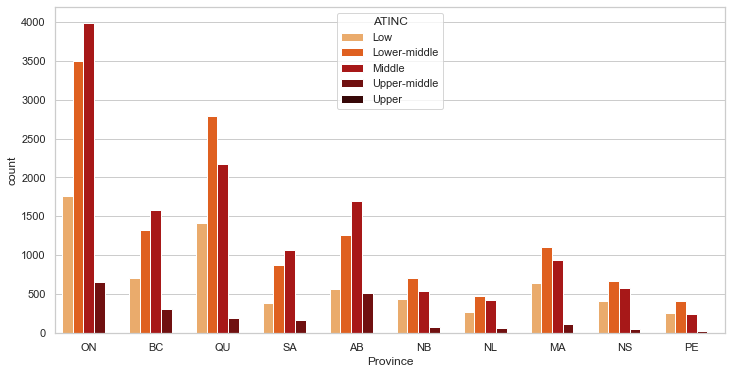

In [52]:
rcParams['figure.figsize'] = 12,6
sns.countplot(data=df,x='PROV', hue='ATINC', palette="gist_heat_r").set(xlabel='Province');

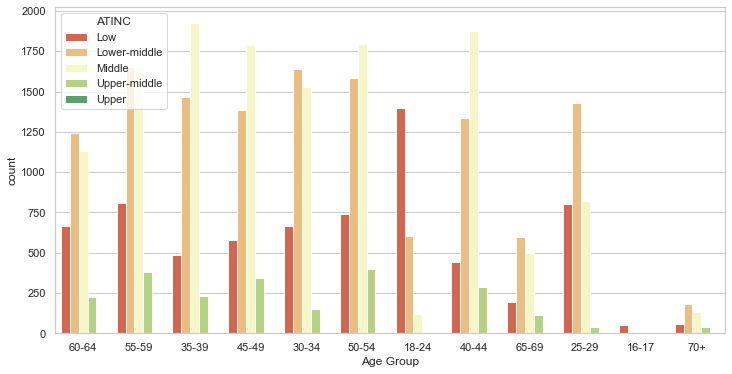

In [53]:
sns.countplot(data=df,x='AGEGP', hue='ATINC', palette="RdYlGn").set(xlabel='Age Group');


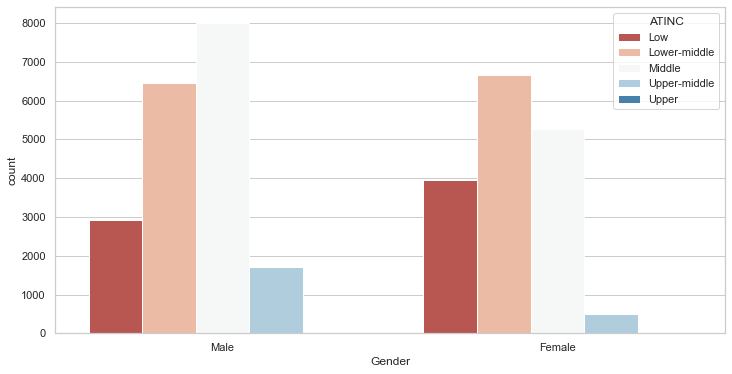

In [54]:
sns.countplot(data=df,x='SEX', hue='ATINC', palette="RdBu").set(xlabel='Gender');

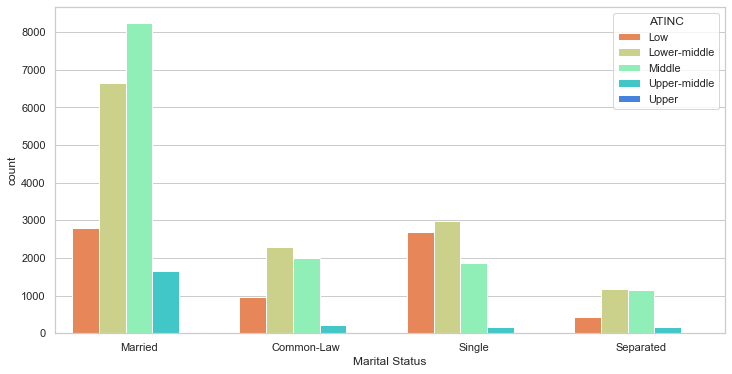

In [55]:
# Individual income distribution by marital status
sns.countplot(data=df,x='MARSTP', hue='ATINC', palette="rainbow_r").set(xlabel='Marital Status');

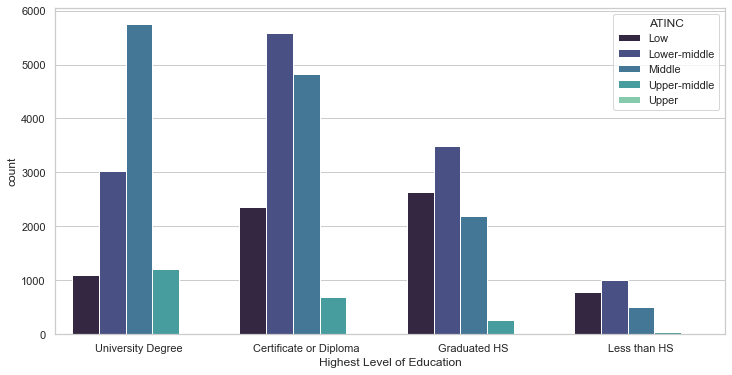

In [56]:
# Individual income distribution by highest level of education
sns.countplot(data=df,x='HLEV2G', hue='ATINC', palette="mako").set(xlabel='Highest Level of Education');

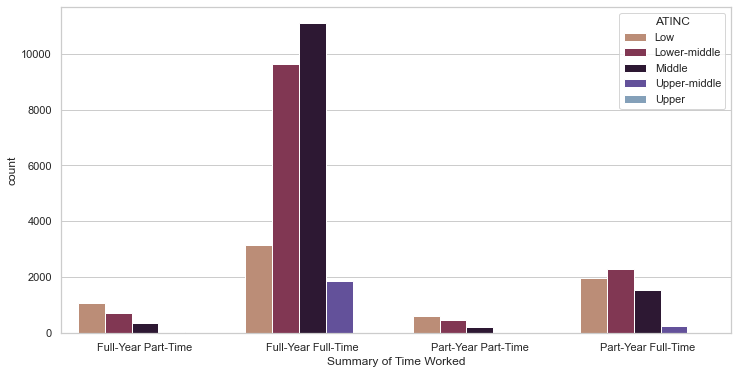

In [57]:
# Individual income distribution by summary of time worked
sns.countplot(data=df,x='SCSUM', hue='ATINC', palette="twilight_r").set(xlabel='Summary of Time Worked');

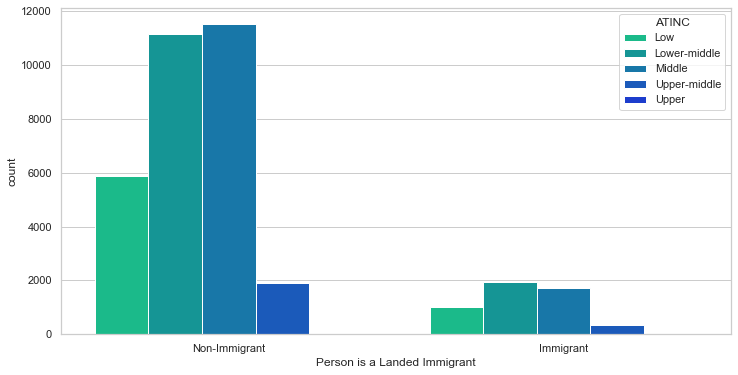

In [58]:
# Individual income distribution by if person is a landed immigrant 
sns.countplot(data=df,x='IMMST', hue='ATINC', palette="winter_r").set(xlabel='Person is a Landed Immigrant');

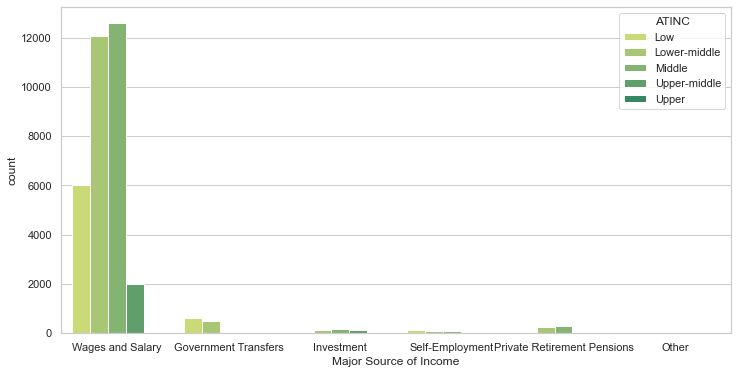

In [59]:
# Individual income distribution by major source of income 
sns.countplot(data=df,x='MAJRI', hue='ATINC', palette="summer_r").set(xlabel='Major Source of Income');

Number of samples based on income levels
Low: 6882
Low-middle: 13114
Middle: 13270
Upper-middle: 2220
Upper: 28


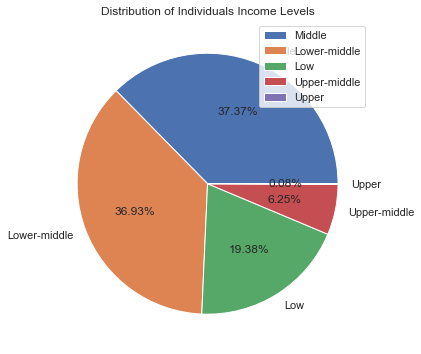

In [60]:
# Visualization of our samples based on income levels
print("Number of samples based on income levels")
print("Low:", df.loc[df['ATINC']=="Low"].count()['ATINC'])
print("Low-middle:", df.loc[df['ATINC']=="Lower-middle"].count()['ATINC'])
print("Middle:", df.loc[df['ATINC']=="Middle"].count()['ATINC'])
print("Upper-middle:", df.loc[df['ATINC']=="Upper-middle"].count()['ATINC'])
print("Upper:", df.loc[df['ATINC']=="Upper"].count()['ATINC'])

dist = df['ATINC'].value_counts(normalize=True)*100
plt.pie(dist, labels=dist.index,  autopct= '%2.2f%%');
plt.legend(dist.index, loc="best");
plt.title('Distribution of Individuals Income Levels');

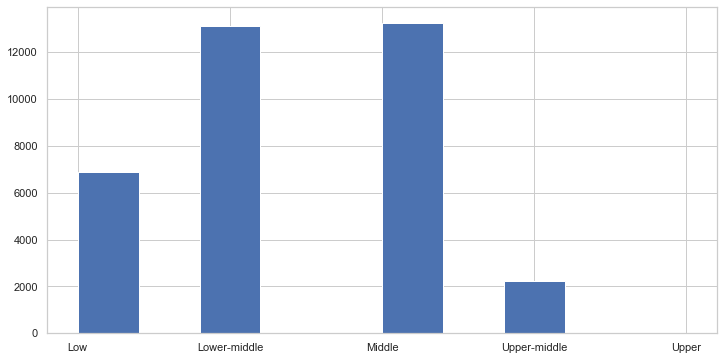

In [61]:
df['ATINC'].hist();

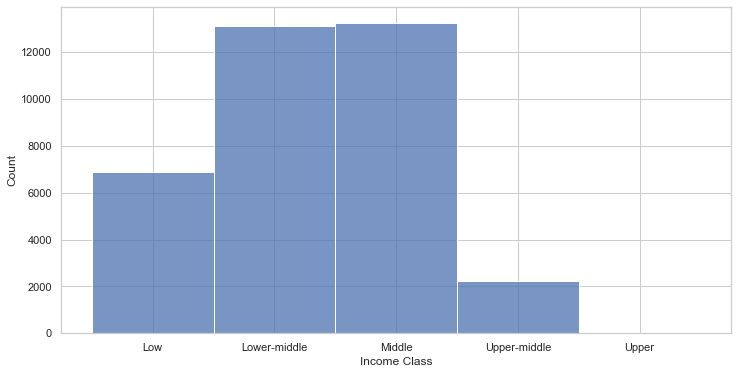

In [62]:
sns.histplot(data=df, x='ATINC').set(xlabel='Income Class');

# Implementing Models

In [63]:
# Getting the data
X = df_m.drop('ATINC', axis=1).to_numpy()
y = df_m['ATINC'].to_numpy()

# Partition the data into trianing and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

print('X_train size : ',X_train.shape)
print('X_valid size : ',X_valid.shape)
print('y_train size : ',y_train.shape)
print('y_valid size : ',y_valid.shape)

X_train size :  (26635, 13)
X_valid size :  (8879, 13)
y_train size :  (26635,)
y_valid size :  (8879,)


In [64]:
from sklearn.metrics import classification_report
# naive baye classifier 
bayes_model = make_pipeline(
    StandardScaler(),
    GaussianNB()
)
bayes_model.fit(X_train, y_train)
print(bayes_model.score(X_train, y_train))
print(bayes_model.score(X_valid, y_valid))
print(classification_report(y_valid, bayes_model.predict(X_valid), target_names=df['ATINC'].unique()))

0.8219635817533321
0.8204752787476067
              precision    recall  f1-score   support

         Low       0.74      0.84      0.79      1687
Lower-middle       0.79      0.81      0.80      3317
      Middle       0.92      0.83      0.87      3307
Upper-middle       0.11      0.88      0.20         8
       Upper       0.82      0.78      0.80       560

    accuracy                           0.82      8879
   macro avg       0.68      0.83      0.69      8879
weighted avg       0.83      0.82      0.82      8879



In [65]:
# k-nearest neighbours classifier 
knn_model = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=10)
)
knn_model.fit(X_train, y_train)
print(knn_model.score(X_train, y_train))
print(knn_model.score(X_valid, y_valid))
print(classification_report(y_valid, knn_model.predict(X_valid), target_names=df['ATINC'].unique()))

0.8153932795194293
0.7638247550399819
              precision    recall  f1-score   support

         Low       0.71      0.63      0.67      1687
Lower-middle       0.69      0.82      0.75      3317
      Middle       0.87      0.80      0.83      3307
Upper-middle       1.00      0.38      0.55         8
       Upper       0.93      0.64      0.76       560

    accuracy                           0.76      8879
   macro avg       0.84      0.65      0.71      8879
weighted avg       0.78      0.76      0.76      8879



In [66]:
# random forest classifer 
rf_model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(n_estimators=100, max_depth=13, min_samples_leaf=10)
)
rf_model.fit(X_train, y_train)
print(rf_model.score(X_train, y_train))
print(rf_model.score(X_valid, y_valid))
print(classification_report(y_valid, rf_model.predict(X_valid), target_names=df['ATINC'].unique()))

0.9270508729115825
0.9105755152607276
              precision    recall  f1-score   support

         Low       0.85      0.92      0.89      1687
Lower-middle       0.89      0.90      0.89      3317
      Middle       0.96      0.92      0.94      3307
Upper-middle       0.60      0.38      0.46         8
       Upper       0.95      0.91      0.93       560

    accuracy                           0.91      8879
   macro avg       0.85      0.80      0.82      8879
weighted avg       0.91      0.91      0.91      8879



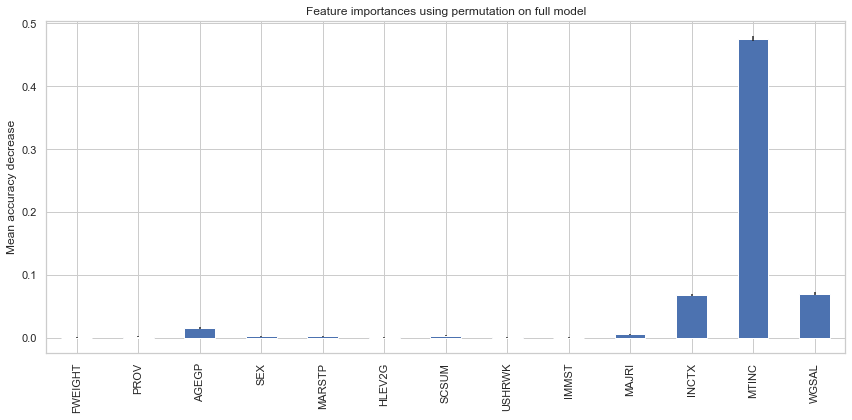

In [68]:
# feature importance
result = permutation_importance(
    rf_model, X_valid, y_valid, n_repeats=10, random_state=0, n_jobs=-1
)

forest_importances = pd.Series(result.importances_mean, index=df.drop(columns='ATINC').columns)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()

In [55]:
# SVC
svc_model = make_pipeline(
    StandardScaler(),
    SVC(kernel='linear', C=1.0)
)
svc_model.fit(X_train, y_train) 
print(svc_model.score(X_train, y_train))
print(svc_model.score(X_valid, y_valid))
print(classification_report(y_valid, svc_model.predict(X_valid), target_names=df['ATINC'].unique()))

0.8866529003191289
0.8883883320193715
              precision    recall  f1-score   support

         Low       0.84      0.83      0.84      1732
Lower-middle       0.84      0.88      0.86      3240
      Middle       0.95      0.92      0.93      3351
Upper-middle       0.86      0.86      0.86         7
       Upper       0.97      0.95      0.96       549

    accuracy                           0.89      8879
   macro avg       0.89      0.89      0.89      8879
weighted avg       0.89      0.89      0.89      8879



In [56]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_valid, svc_model.predict(X_valid), labels=df['ATINC'].unique())

array([[1436,  296,    0,    0,    0],
       [ 263, 2846,  131,    0,    0],
       [   4,  256, 3078,   13,    0],
       [   0,    0,   26,  522,    1],
       [   0,    0,    0,    1,    6]])

In [57]:
# Showing the incorrect predictions of the SVC model
predictions = model.predict(X_valid)
result = pd.DataFrame({'truth': y_valid, 'prediction': model.predict(X_valid)})
print(result[result['truth'] != result['prediction']])

NameError: name 'model' is not defined

: 